Лучшие параметры: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}


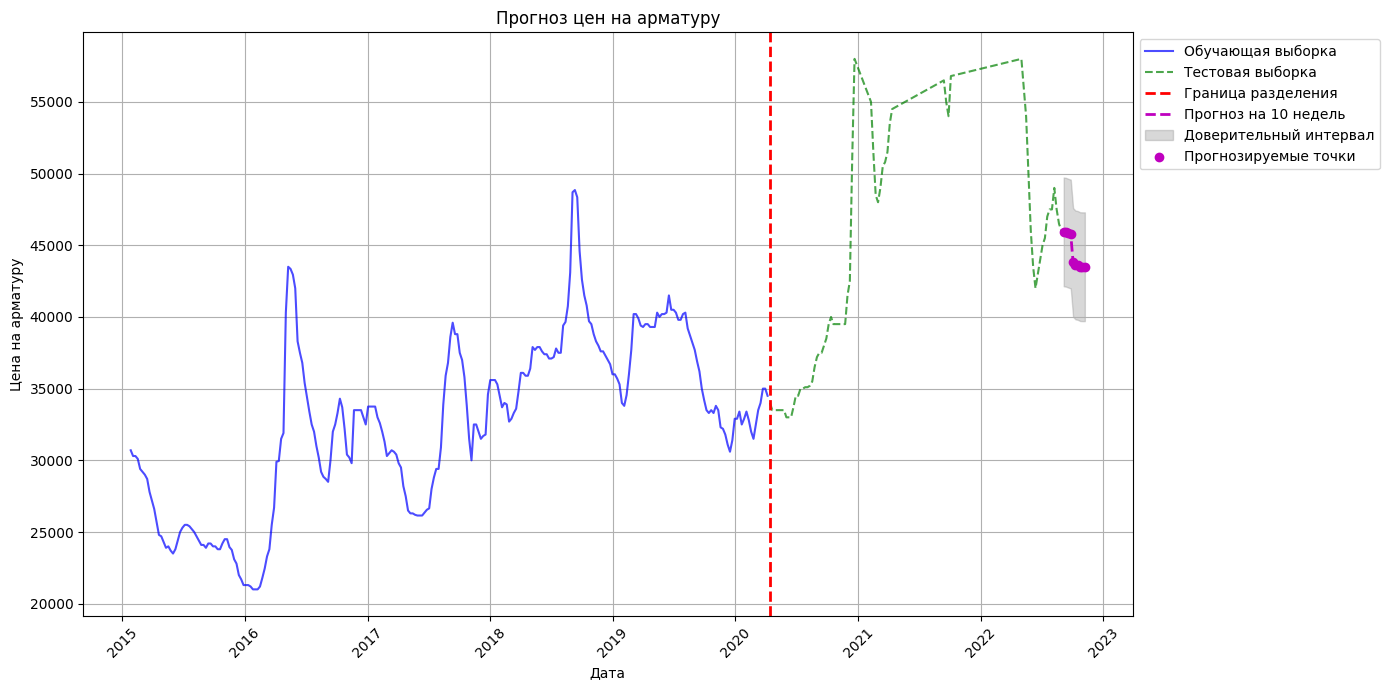


Прогноз на следующие 10 недель:
Дата: 2022-09-05 | Цена: 45934.25
Дата: 2022-09-12 | Цена: 45906.45
Дата: 2022-09-19 | Цена: 45840.70
Дата: 2022-09-26 | Цена: 45781.63
Дата: 2022-10-03 | Цена: 43801.27
Дата: 2022-10-10 | Цена: 43626.47
Дата: 2022-10-17 | Цена: 43591.47
Дата: 2022-10-24 | Цена: 43509.33
Дата: 2022-10-31 | Цена: 43500.66
Дата: 2022-11-07 | Цена: 43500.66

Оценка модели:
R² на обучающей выборке: 0.99
R² на тестовой выборке: 0.62

Метрики качества модели:
R2_train: 0.99
R2_test: 0.62
MAE: 3145.15
RMSE: 4803.57

Прогноз сохранен в файл forecast.csv

Модель сохранена в файл random_forest_model.joblib


In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import joblib

# 1. Загрузка данных
df = pd.read_excel("train (3).xlsx")
df['dt'] = pd.to_datetime(df['dt'])
df = df.sort_values(by='dt')  # Сортировка по времени

# Проверка на пропуски
if df.isnull().values.any():
    print("В данных есть пропуски!")
    df = df.dropna()

# Обработка выбросов
Q1 = df['Цена на арматуру'].quantile(0.25)
Q3 = df['Цена на арматуру'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Цена на арматуру'] >= lower_bound) & (df['Цена на арматуру'] <= upper_bound)]

# Создаем признаки
df['year'] = df['dt'].dt.year
df['unique_week'] = df['year'] * 100 + df['dt'].dt.isocalendar().week
df['month'] = df['dt'].dt.month
df['day_of_year'] = df['dt'].dt.dayofyear
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['rolling_mean'] = df['Цена на арматуру'].rolling(window=4).mean()
df['weekday'] = df['dt'].dt.weekday  # День недели
df['lag_1'] = df['Цена на арматуру'].shift(1)  # Лаговая переменная
df = df.dropna()  # Удаление строк с NaN


# Подготовка данных
X = df[['unique_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'rolling_mean', 'weekday', 'lag_1']].values
y = df['Цена на арматуру'].values

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Настройка гиперпараметров через GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
model = grid_search.best_estimator_

# Прогноз на 10 недель вперед
last_week = X[-1][0]
future_weeks = np.arange(last_week + 1, last_week + 11).reshape(-1, 1)

# Добавляем месяцы и дни года для новых недель
last_date = df['dt'].iloc[-1] - timedelta(days=df['dt'].iloc[-1].weekday())
future_dates = []
future_rolling_means = [df['rolling_mean'].iloc[-1]]  # Начинаем с последнего значения
future_predictions_temp = []  # Временный список для хранения прогнозов

for i in range(len(future_weeks)):
    future_date = last_date + timedelta(weeks=int(future_weeks.flatten()[i] - last_week))  # Исправленная строка
    future_dates.append(future_date)

    # Рекурсивно обновляем скользящее среднее
    if i == 0:
        rolling_mean_future = (future_rolling_means[-1] * 3 + y_test[-1]) / 4
    else:
        rolling_mean_future = (future_rolling_means[-1] * 3 + future_predictions_temp[i - 1]) / 4
    future_rolling_means.append(rolling_mean_future)

    # Формируем признаки для прогноза
    future_features = [
        (future_date.year * 100 + future_date.isocalendar().week),
        np.sin(2 * np.pi * future_date.month / 12),
        np.cos(2 * np.pi * future_date.month / 12),
        np.sin(2 * np.pi * future_date.timetuple().tm_yday / 365),
        np.cos(2 * np.pi * future_date.timetuple().tm_yday / 365),
        rolling_mean_future,
        future_date.weekday(),
        future_predictions_temp[i - 1] if i > 0 else y_test[-1]
    ]

    # Делаем прогноз для текущей недели
    prediction = model.predict(np.array([future_features]))[0]
    future_predictions_temp.append(prediction)

future_predictions = np.array(future_predictions_temp)  # Преобразуем в массив

# Визуализация
plt.figure(figsize=(14, 7))

# Разделение данных на обучающую и тестовую выборки
train_dates = df['dt'][:len(y_train)]  # Даты для обучающей выборки
test_dates = df['dt'][len(y_train):]  # Даты для тестовой выборки

# Построение графиков обучающей и тестовой выборок
plt.plot(train_dates, y_train, 'b-', label='Обучающая выборка', alpha=0.7)  # Сплошная линия для обучающей выборки
plt.plot(test_dates, y_test, 'g--', label='Тестовая выборка', alpha=0.7)    # Пунктирная линия для тестовой выборки

# Добавление вертикальной линии для разделения
split_date = df['dt'].iloc[len(y_train)]
plt.axvline(x=split_date, color='red', linestyle='--', linewidth=2, label='Граница разделения')

# Прогноз на 10 недель
error_std = np.std(y_test - model.predict(X_test))  # Стандартное отклонение ошибок
plt.plot(future_dates, future_predictions, 'm--', linewidth=2, label='Прогноз на 10 недель')
plt.fill_between(
    future_dates,
    future_predictions - error_std,
    future_predictions + error_std,
    color='gray',
    alpha=0.3,
    label='Доверительный интервал'
)
plt.scatter(future_dates, future_predictions, c='m', zorder=5, label='Прогнозируемые точки')

# Настройка графика
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Прогноз цен на арматуру')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecast_plot.png", dpi=300, bbox_inches='tight')
plt.show()
# Вывод прогноза
print("\nПрогноз на следующие 10 недель:")
for date, price in zip(future_dates, future_predictions):
    print(f"Дата: {date.strftime('%Y-%m-%d')} | Цена: {price:.2f}")
# Оценка модели на обучающей и тестовой выборках
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Расчет метрик
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Вывод метрик
print("\nОценка модели:")
print(f"R² на обучающей выборке: {train_r2:.2f}")
print(f"R² на тестовой выборке: {test_r2:.2f}")

# Дополнительно: Сохранение метрик в файл
metrics = {
    'R2_train': train_r2,
    'R2_test': test_r2,
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
}

print("\nМетрики качества модели:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Сохранение метрик в файл
with open("metrics.txt", "w") as f:
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.2f}\n")
# Сохранение прогнозов в файл
forecast_df = pd.DataFrame({
    'Дата': future_dates,
    'Прогнозируемая цена': future_predictions
})
forecast_df.to_csv("forecast.csv", index=False)
print("\nПрогноз сохранен в файл forecast.csv")

# Сохранение модели
joblib.dump(model, "random_forest_model.joblib")
print("\nМодель сохранена в файл random_forest_model.joblib")